In [1]:
#import library
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
from transformers import pipeline
!pip install finnhub-python
import finnhub
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax


In [2]:
stock_data = yf.download('AAPL',start='2022-1-1',end=datetime.today())

[*********************100%***********************]  1 of 1 completed


In [3]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,177.830002,182.880005,177.710007,182.009995,179.273605,104487900
2022-01-04,182.630005,182.940002,179.119995,179.699997,176.998337,99310400
2022-01-05,179.610001,180.169998,174.639999,174.919998,172.290176,94537600
2022-01-06,172.699997,175.300003,171.639999,172.000000,169.414108,96904000
2022-01-07,172.889999,174.139999,171.029999,172.169998,169.581543,86709100


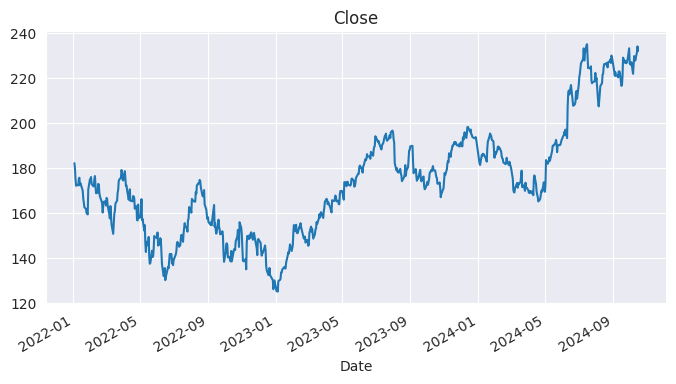

In [4]:
# @title Close

from matplotlib import pyplot as plt
stock_data['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

In [5]:
finnhub_client = finnhub.Client(api_key="cnl0n1pr01qjvabn3kngcnl0n1pr01qjvabn3ko0")
news = pd.DataFrame(finnhub_client.company_news('AAPL', _from="2023-01-01", to='2024-01-01')).drop(columns=['id','image','category'])
news['datetime'] = pd.to_datetime(news['datetime'], unit='s').dt.strftime('%Y-%m-%d')
news['datetime'] = pd.to_datetime(news['datetime'])



In [6]:
news.loc[217]

,217
datetime,2023-12-27 00:00:00
headline,Meta Platforms: Potential $500 Target In 2024
related,AAPL
source,SeekingAlpha
summary,Meta Platforms has experienced a significant r...
url,https://finnhub.io/api/news?id=3a1ee352637478c...


In [7]:
news.loc[0,'summary']

'Legendary investor Warren Buffett has long preached the importance of passive investing in large-cap stocks. "Beware the investment activity that produces applause; the great moves are usually greeted by yawns," said Buffett, who also is a big fan of dividend-yielding stocks, which he calls the secret sauce to Berkshire Hathaway Inc.\'s success. Nearly 75% of Buffett\'s portfolio is invested in just five stocks. Take a closer look. Apple Buffett has been a long-time supporter of Apple Inc. (NASDAQ'

In [8]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = softmax(outputs.logits, dim=1)
    sentiment_index = probs.argmax().item()
    label_mapping = {0: -1, 1: 0, 2: 1}
    return label_mapping[sentiment_index]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [9]:
news['sentiment'] = news['headline'].apply(predict_sentiment)

In [10]:
news.head()

,datetime,headline,related,source,summary,url,sentiment
0,2024-01-01,Buffett's Bullseye: Meet The 4 Stocks That Mak...,AAPL,Yahoo,Legendary investor Warren Buffett has long pre...,https://finnhub.io/api/news?id=d1fec8e1b6865f2...,1
1,2024-01-01,"Apple: Accept The Gift, Move On",AAPL,SeekingAlpha,Apple's stock rally in 2023 appears unjustifie...,https://finnhub.io/api/news?id=87006add4f77d76...,1
2,2024-01-01,"Investing Preview 2024: Buy These 4 ""Magnifice...",AAPL,Yahoo,"The ""Magnificent Seven"" stocks have varying va...",https://finnhub.io/api/news?id=bde2935c2d3afab...,1
3,2024-01-01,"Which ""Magnificent Seven"" Stocks Are Screaming...",AAPL,Yahoo,Only three of the seven make the cut as buys a...,https://finnhub.io/api/news?id=f223266eaef9e60...,1
4,2024-01-01,10 Information Technology Stocks With Whale Al...,AAPL,Benzinga,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=2472b688f93a741...,1


In [11]:
sentiments = pd.concat([news["datetime"], news["sentiment"]], axis=1)
sentiments.head()

,datetime,sentiment
0,2024-01-01,1
1,2024-01-01,1
2,2024-01-01,1
3,2024-01-01,1
4,2024-01-01,1


In [12]:
sentiments = sentiments.groupby("datetime").agg('sum').reset_index()
print(sentiments)


    datetime  sentiment
0 2023-12-27         15
1 2023-12-28         27
2 2023-12-29         15
3 2023-12-30         12
4 2023-12-31         13
5 2024-01-01          9


In [13]:
#calculate the close diff between the day we got our sentiment and next day close: this model seems not very ideal?

merged_df = pd.merge(sentiments, stock_data, how='left', left_on='datetime', right_on='Date')
merged_df['Close_next_day'] = merged_df['Close'].shift(-1)
merged_df['close_diff'] = merged_df['Close_next_day'] - merged_df['Close']
final_df = merged_df[['datetime', 'sentiment', 'close_diff']].copy()
print(final_df)

    datetime  sentiment  close_diff
0 2023-12-27         15    0.430008
1 2023-12-28         27   -1.050003
2 2023-12-29         15         NaN
3 2023-12-30         12         NaN
4 2023-12-31         13         NaN
5 2024-01-01          9         NaN


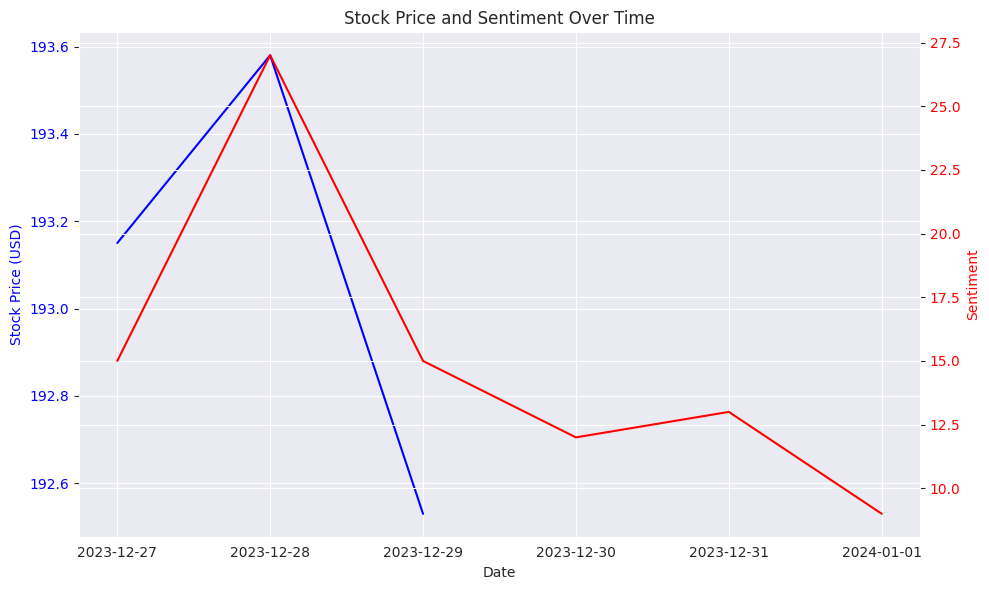

In [14]:
# create a visual to asses stock price and sentiment

# plot stock price and sentiment
fig, ax1 = plt.subplots(figsize=(10, 6))

# plot stock price
ax1.plot(merged_df['datetime'], merged_df['Close'], color='b', label='Stock Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price (USD)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# create a second y-axis for sentiment
ax2 = ax1.twinx()
ax2.plot(merged_df['datetime'], merged_df['sentiment'], color='r', label='Sentiment')
ax2.set_ylabel('Sentiment', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Stock Price and Sentiment Over Time')
fig.tight_layout()
plt.show()

In [15]:
# Identify ups and down then categorize them with (0 and 1)
# categorize stock movement (1 = up, 0 = down)
final_df['movement'] = final_df['close_diff'].apply(lambda x: 1 if x > 0 else 0)
final_df.head()

,datetime,sentiment,close_diff,movement
0,2023-12-27,15,0.430008,1
1,2023-12-28,27,-1.050003,0
2,2023-12-29,15,NaN,0
3,2023-12-30,12,NaN,0
4,2023-12-31,13,NaN,0


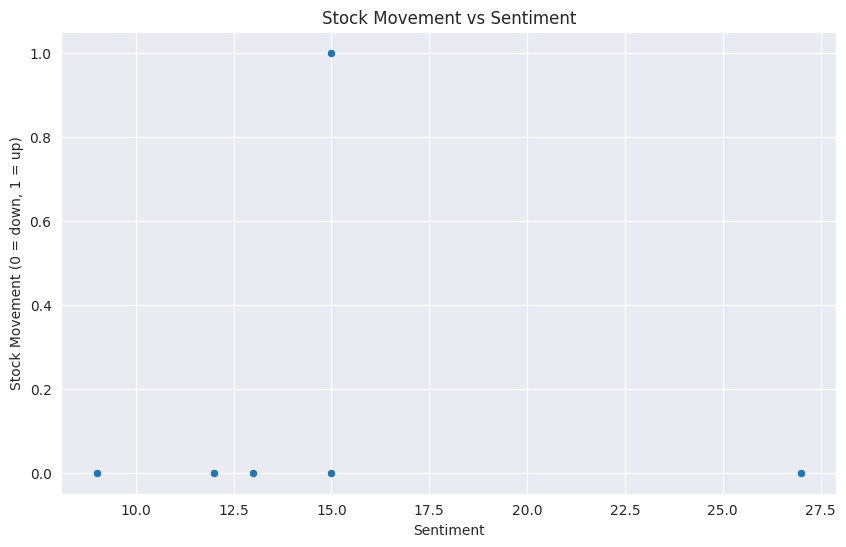

In [17]:
# Create visual for stock mouvement and sentiment
# visualize stock movement and sentiment
fig, ax = plt.subplots(figsize=(10, 6))

# scatter plot of sentiment vs stock movement
sns.scatterplot(x='sentiment', y='movement', data=final_df, ax=ax)
ax.set_title('Stock Movement vs Sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Stock Movement (0 = down, 1 = up)')

plt.show()

In [18]:
# is there any correlation between stock price and news?
correlation = final_df[['sentiment', 'close_diff']].corr()
print(correlation)

            sentiment  close_diff
sentiment         1.0        -1.0
close_diff       -1.0         1.0
